In [1]:
import tensorflow as tf
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from keras.layers import Input, Dense, GlobalAveragePooling2D, UpSampling2D, add, concatenate, Conv2D, Lambda, BatchNormalization, LeakyReLU, MaxPool2D, LSTM, GRU

In [2]:
df = pd.read_csv("dataset/Video Information Extraction.csv")

In [3]:
df.head()

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
0,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720,book
1,25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,7069,462,44,949,720,book
2,25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,7068,234,17,524,414,book
3,25,-1,1,22,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,7070,131,26,526,480,book
4,25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/book.mp4,0,7099,162,54,528,400,book


We need to remove the identity of the unpreserved video

In [5]:
record = pickle.load(open("final_record_cleaned.pkl", "rb"))

In [6]:
video_id_kept = list(record.keys())
video_id_kept = [int(id.replace('.mp4', '')) for id in video_id_kept]

In [7]:
new_df = df[df["video_id"].isin(video_id_kept)]

In [8]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
0,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720,book
8,25,-1,1,11,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,17710,196,15,521,414,drink
12,25,-1,1,19,52,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,17711,289,9,783,480,drink
14,25,-1,1,21,21,asldeafined,test,https://media.asldeafined.com/vocabulary/14677...,0,17713,28,0,542,480,drink
15,25,-1,1,27,2,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/1...,0,17709,41,9,257,240,drink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11968,25,-1,1,5,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/7/7474.mp4,0,62492,69,16,219,192,waterfall
11969,25,-1,1,6,12,aslsearch,train,http://www.aslsearch.com/signs/videos/waterfal...,0,62493,203,55,549,400,waterfall
11970,25,-1,1,3,19,elementalasl,train,https://elementalaslconcepts.weebly.com/upload...,0,62782,89,4,242,180,weigh
11973,25,-1,1,2,4,signschool,test,https://signstock.blob.core.windows.net/signsc...,0,63044,415,86,1811,1080,wheelchair


Reordering dataframe

In [9]:
new_df = new_df.sort_values(by=["video_id"]) 

In [10]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
8751,25,-1,1,2,2,spreadthesign,test,https://media.spreadthesign.com/video/mp4/13/1...,0,335,57,5,246,240,abdomen
8752,25,-1,1,3,13,asldeafined,train,https://media.asldeafined.com/vocabulary/14688...,0,336,103,0,565,480,abdomen
8756,25,-1,1,1,2,spreadthesign,test,https://media.spreadthesign.com/video/mp4/13/1...,0,376,61,5,247,240,able
8757,25,-1,1,2,15,asldeafined,train,https://media.asldeafined.com/vocabulary/14667...,0,377,69,17,552,480,able
1709,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/3...,0,414,64,27,241,240,about
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/white.mp4,0,69533,366,40,875,720,white
7446,25,-1,1,1,116,aslbrick,train,http://aslbricks.org/New/ASL-Videos/worm.mp4,0,69541,282,4,937,720,worm
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write
1049,25,-1,1,1,118,aslbrick,test,http://aslbricks.org/New/ASL-Videos/yellow.mp4,0,69545,256,41,883,720,yellow


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

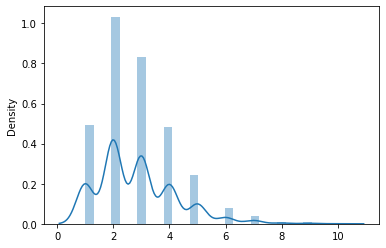

In [11]:
sns.distplot(np.array(new_df["gloss"].value_counts()))

Easy mode : Removing classes with less than 5 elements

In [12]:
val_count = dict(new_df["gloss"].value_counts())

In [13]:
single_classes = [key for key in val_count.keys() if val_count[key] < 5]

In [14]:
len(single_classes)

1724

In [15]:
new_df = new_df[~new_df["gloss"].isin(single_classes)]

In [16]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
565,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/1...,1,623,54,6,272,240,accident
556,25,-1,1,2,29,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/7...,0,624,42,6,278,240,accident
557,25,-1,1,3,6,signschool,test,https://signstock.blob.core.windows.net/signsc...,1,625,675,50,1461,1080,accident
558,25,-1,1,4,32,signschool,val,https://signstock.blob.core.windows.net/signsc...,0,626,485,85,1608,1080,accident
561,25,-1,1,7,13,asldeafined,train,https://media.asldeafined.com/vocabulary/14661...,0,629,69,23,613,480,accident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6015,25,-1,1,1,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/up.mp4,0,69522,280,39,883,720,up
3005,25,-1,1,1,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/when.mp4,0,69532,286,40,894,720,when
537,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/white.mp4,0,69533,366,40,875,720,white
1049,25,-1,1,1,118,aslbrick,test,http://aslbricks.org/New/ASL-Videos/yellow.mp4,0,69545,256,41,883,720,yellow


Reordering records

In [17]:
sorted_record = { key : record[key] for key in sorted(record.keys()) if int(key.replace(".mp4", "")) in list(new_df["video_id"])}

In [18]:
len(sorted_record)

1291

## Prepare dataset

In [19]:
X = np.array(list(sorted_record.values()))

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(np.array(list(new_df["gloss"])).reshape(-1,1))
y = encoder.transform(np.array(list(new_df["gloss"])).reshape(-1,1)).toarray()

In [20]:
le = LabelEncoder()
y_ = le.fit_transform(np.array(list(new_df["gloss"])))

In [21]:
y_.shape

(1291,)

In [22]:
print(X.shape, y.shape)

(1291, 520, 100, 3) (1291, 231)


In [23]:
X = X.reshape(X.shape[0], X.shape[2], X.shape[1], X.shape[3])

In [24]:
input_dim = X.shape[1:]
nb_classes = y.shape[-1]

## Model implementation

In [31]:
model = Sequential()
model.add(Input(shape=(input_dim)))
model.add(Conv2D(filters=8, kernel_size= 3, strides = (1, 2), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(input_dim[0], 3), strides = (1, 2), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size= 3, strides = (1, 2),padding='same', activation='relu'))
model.add(tf.keras.layers.Reshape((100, 65*32)))
model.add(LSTM(64))
model.add(Dense(128, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 260, 8)       224       
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 130, 16)      38416     
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 65, 32)       4640      
                                                                 
 reshape_2 (Reshape)         (None, 100, 2080)         0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                549120    
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 231)              

In [33]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

Epoch 1/10
15/15 [==============================] - 69s 4s/step - loss: 5.4646 - accuracy: 0.0011 - val_loss: 5.4581 - val_accuracy: 0.0026
Epoch 2/10
15/15 [==============================] - 71s 5s/step - loss: 5.3828 - accuracy: 0.0266 - val_loss: 5.4741 - val_accuracy: 0.0129
Epoch 3/10
15/15 [==============================] - 66s 4s/step - loss: 5.3067 - accuracy: 0.0642 - val_loss: 5.4751 - val_accuracy: 0.0077
Epoch 4/10
15/15 [==============================] - 67s 4s/step - loss: 5.2314 - accuracy: 0.0797 - val_loss: 5.4985 - val_accuracy: 0.0129
Epoch 5/10
15/15 [==============================] - 69s 5s/step - loss: 5.1387 - accuracy: 0.1019 - val_loss: 5.5165 - val_accuracy: 0.0129
Epoch 6/10
15/15 [==============================] - 64s 4s/step - loss: 5.0534 - accuracy: 0.0997 - val_loss: 5.5492 - val_accuracy: 0.0129
Epoch 7/10
15/15 [==============================] - 63s 4s/step - loss: 4.9329 - accuracy: 0.1118 - val_loss: 5.6119 - val_accuracy: 0.0155
Epoch 8/10
15/15 [==

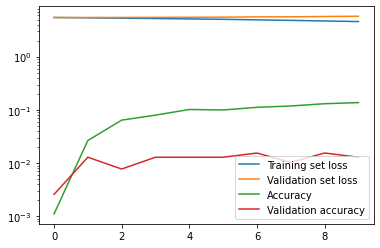

Epoch 1/10
15/15 [==============================] - 64s 4s/step - loss: 4.8766 - accuracy: 0.1163 - val_loss: 4.8844 - val_accuracy: 0.1057
Epoch 2/10
15/15 [==============================] - 63s 4s/step - loss: 4.7247 - accuracy: 0.1274 - val_loss: 4.9257 - val_accuracy: 0.0902
Epoch 3/10
15/15 [==============================] - 63s 4s/step - loss: 4.5865 - accuracy: 0.1362 - val_loss: 5.0107 - val_accuracy: 0.0670
Epoch 4/10
15/15 [==============================] - 63s 4s/step - loss: 4.4937 - accuracy: 0.1351 - val_loss: 5.0713 - val_accuracy: 0.0619
Epoch 5/10
15/15 [==============================] - 27999s 2000s/step - loss: 4.3641 - accuracy: 0.1573 - val_loss: 5.1806 - val_accuracy: 0.0387
Epoch 6/10
15/15 [==============================] - 72s 5s/step - loss: 4.2579 - accuracy: 0.1739 - val_loss: 5.2154 - val_accuracy: 0.0438
Epoch 7/10
15/15 [==============================] - 97s 7s/step - loss: 4.1412 - accuracy: 0.1794 - val_loss: 5.2841 - val_accuracy: 0.0309
Epoch 8/10
15/

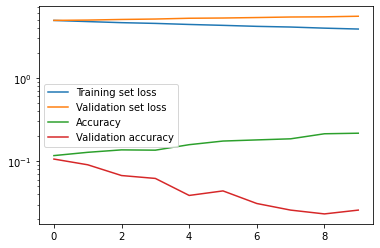

Epoch 1/10
15/15 [==============================] - 61s 4s/step - loss: 4.2160 - accuracy: 0.1683 - val_loss: 4.4404 - val_accuracy: 0.1495
Epoch 2/10
15/15 [==============================] - 60s 4s/step - loss: 4.1051 - accuracy: 0.1938 - val_loss: 4.5430 - val_accuracy: 0.1314
Epoch 3/10
15/15 [==============================] - 59s 4s/step - loss: 4.0290 - accuracy: 0.2093 - val_loss: 4.5976 - val_accuracy: 0.0979
Epoch 4/10
15/15 [==============================] - 61s 4s/step - loss: 3.8923 - accuracy: 0.2082 - val_loss: 4.7022 - val_accuracy: 0.0902
Epoch 5/10
15/15 [==============================] - 64s 4s/step - loss: 3.8227 - accuracy: 0.2315 - val_loss: 4.7936 - val_accuracy: 0.0722
Epoch 6/10
15/15 [==============================] - 64s 4s/step - loss: 3.7489 - accuracy: 0.2425 - val_loss: 4.8279 - val_accuracy: 0.0696
Epoch 7/10
15/15 [==============================] - 64s 4s/step - loss: 3.6266 - accuracy: 0.2636 - val_loss: 4.9187 - val_accuracy: 0.0541
Epoch 8/10
15/15 [==

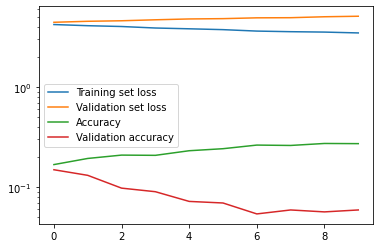

Epoch 1/10
15/15 [==============================] - 59s 4s/step - loss: 3.8193 - accuracy: 0.2303 - val_loss: 4.1117 - val_accuracy: 0.1830
Epoch 2/10
15/15 [==============================] - 60s 4s/step - loss: 3.6929 - accuracy: 0.2414 - val_loss: 4.2070 - val_accuracy: 0.1649
Epoch 3/10
15/15 [==============================] - 49s 3s/step - loss: 3.5837 - accuracy: 0.2625 - val_loss: 4.2789 - val_accuracy: 0.1418
Epoch 4/10
15/15 [==============================] - 50s 3s/step - loss: 3.4913 - accuracy: 0.2813 - val_loss: 4.3174 - val_accuracy: 0.1366
Epoch 5/10
15/15 [==============================] - 51s 3s/step - loss: 3.4282 - accuracy: 0.2791 - val_loss: 4.3971 - val_accuracy: 0.1340
Epoch 6/10
15/15 [==============================] - 51s 3s/step - loss: 3.3143 - accuracy: 0.2924 - val_loss: 4.4236 - val_accuracy: 0.1134
Epoch 7/10
15/15 [==============================] - 51s 3s/step - loss: 3.2395 - accuracy: 0.3090 - val_loss: 4.5121 - val_accuracy: 0.1057
Epoch 8/10
15/15 [==

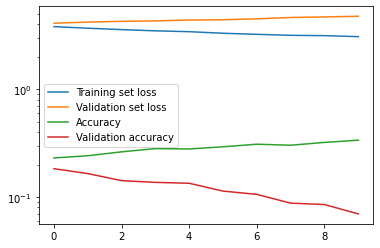

Epoch 1/10
15/15 [==============================] - 49s 3s/step - loss: 3.5261 - accuracy: 0.2835 - val_loss: 3.6041 - val_accuracy: 0.2423
Epoch 2/10
15/15 [==============================] - 49s 3s/step - loss: 3.3921 - accuracy: 0.2924 - val_loss: 3.7164 - val_accuracy: 0.2268
Epoch 3/10
15/15 [==============================] - 49s 3s/step - loss: 3.2565 - accuracy: 0.3178 - val_loss: 3.8185 - val_accuracy: 0.1907
Epoch 4/10
15/15 [==============================] - 49s 3s/step - loss: 3.1778 - accuracy: 0.3167 - val_loss: 3.9551 - val_accuracy: 0.1804
Epoch 5/10
15/15 [==============================] - 49s 3s/step - loss: 3.0978 - accuracy: 0.3444 - val_loss: 4.0203 - val_accuracy: 0.1598
Epoch 6/10
15/15 [==============================] - 50s 3s/step - loss: 2.9855 - accuracy: 0.3621 - val_loss: 4.1079 - val_accuracy: 0.1572
Epoch 7/10
15/15 [==============================] - 51s 3s/step - loss: 2.9227 - accuracy: 0.3599 - val_loss: 4.1139 - val_accuracy: 0.1546
Epoch 8/10
15/15 [==

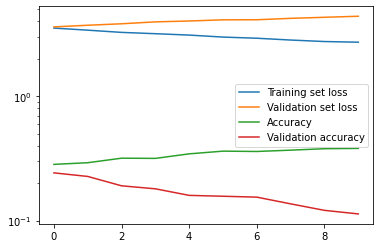

In [34]:
for train_index, test_index in sss.split(X, y_):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.legend(["Training set loss", "Validation set loss", "Accuracy", "Validation accuracy"])

    plt.yscale("log")
    plt.show()

In [35]:
y_pred = model.predict(X)         
y_pred = np.argmax(y_pred, axis = 1)

41/41 [==============================] - 13s 298ms/step


In [36]:
print("F1 score : ", f1_score(y_, y_pred, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred))
print("Precision score : ", precision_score(y_, y_pred, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred, average = 'weighted'))

F1 score :  0.33373316813983167
Accuracy :  0.32532920216886135
Precision score :  0.4282770101369431
Recall score :  0.32532920216886135


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Training only with hands landmarks

In [37]:
X2 = X[:,:,:42]

In [38]:
input_dim_2 = X2.shape[1:]

In [40]:
model2 = Sequential()
model2.add(Input(shape=(input_dim_2)))
model2.add(Conv2D(filters=8, kernel_size= 3, strides = (1, 2), padding='same', activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=(input_dim[0], 3), strides = (1, 2), padding='same', activation='relu'))
model2.add(Conv2D(filters=32, kernel_size= 3, strides = (1, 2),padding='same', activation='relu'))
model2.add(tf.keras.layers.Reshape((100, 6*32)))
model2.add(LSTM(64))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(nb_classes, activation='softmax'))
model2.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 100, 21, 8)        224       
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 11, 16)       38416     
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 6, 32)        4640      
                                                                 
 reshape_4 (Reshape)         (None, 100, 192)          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                65792     
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 231)              

Epoch 1/10
15/15 [==============================] - 7s 350ms/step - loss: 5.4526 - accuracy: 0.0011 - val_loss: 5.4539 - val_accuracy: 0.0077
Epoch 2/10
15/15 [==============================] - 5s 314ms/step - loss: 5.3940 - accuracy: 0.0111 - val_loss: 5.4592 - val_accuracy: 0.0052
Epoch 3/10
15/15 [==============================] - 5s 320ms/step - loss: 5.3434 - accuracy: 0.0255 - val_loss: 5.4750 - val_accuracy: 0.0077
Epoch 4/10
15/15 [==============================] - 5s 325ms/step - loss: 5.2769 - accuracy: 0.0332 - val_loss: 5.4880 - val_accuracy: 0.0077
Epoch 5/10
15/15 [==============================] - 5s 338ms/step - loss: 5.2033 - accuracy: 0.0377 - val_loss: 5.5135 - val_accuracy: 0.0052
Epoch 6/10
15/15 [==============================] - 5s 335ms/step - loss: 5.1233 - accuracy: 0.0443 - val_loss: 5.5873 - val_accuracy: 0.0052
Epoch 7/10
15/15 [==============================] - 5s 334ms/step - loss: 5.0365 - accuracy: 0.0543 - val_loss: 5.6181 - val_accuracy: 0.0052
Epoch 

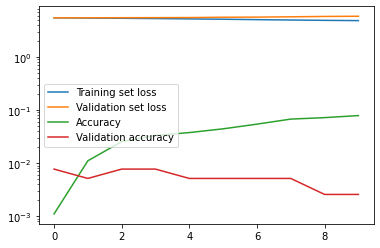

Epoch 1/10
15/15 [==============================] - 6s 370ms/step - loss: 5.0682 - accuracy: 0.0642 - val_loss: 5.1043 - val_accuracy: 0.0541
Epoch 2/10
15/15 [==============================] - 5s 342ms/step - loss: 4.9640 - accuracy: 0.0819 - val_loss: 5.1367 - val_accuracy: 0.0412
Epoch 3/10
15/15 [==============================] - 5s 341ms/step - loss: 4.8719 - accuracy: 0.1041 - val_loss: 5.2047 - val_accuracy: 0.0387
Epoch 4/10
15/15 [==============================] - 6s 374ms/step - loss: 4.7660 - accuracy: 0.1141 - val_loss: 5.2712 - val_accuracy: 0.0258
Epoch 5/10
15/15 [==============================] - 5s 343ms/step - loss: 4.6901 - accuracy: 0.1218 - val_loss: 5.3345 - val_accuracy: 0.0206
Epoch 6/10
15/15 [==============================] - 5s 334ms/step - loss: 4.6437 - accuracy: 0.1274 - val_loss: 5.3959 - val_accuracy: 0.0155
Epoch 7/10
15/15 [==============================] - 5s 332ms/step - loss: 4.5659 - accuracy: 0.1417 - val_loss: 5.4384 - val_accuracy: 0.0129
Epoch 

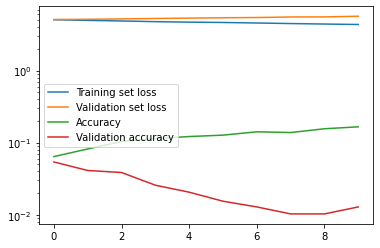

Epoch 1/10
15/15 [==============================] - 5s 333ms/step - loss: 4.7025 - accuracy: 0.1174 - val_loss: 4.7809 - val_accuracy: 0.1237
Epoch 2/10
15/15 [==============================] - 5s 333ms/step - loss: 4.6184 - accuracy: 0.1240 - val_loss: 4.8617 - val_accuracy: 0.0722
Epoch 3/10
15/15 [==============================] - 5s 332ms/step - loss: 4.5436 - accuracy: 0.1307 - val_loss: 4.9219 - val_accuracy: 0.0747
Epoch 4/10
15/15 [==============================] - 5s 333ms/step - loss: 4.4665 - accuracy: 0.1440 - val_loss: 5.0219 - val_accuracy: 0.0619
Epoch 5/10
15/15 [==============================] - 5s 331ms/step - loss: 4.4072 - accuracy: 0.1506 - val_loss: 5.0895 - val_accuracy: 0.0412
Epoch 6/10
15/15 [==============================] - 5s 331ms/step - loss: 4.3715 - accuracy: 0.1440 - val_loss: 5.1275 - val_accuracy: 0.0412
Epoch 7/10
15/15 [==============================] - 5s 332ms/step - loss: 4.3119 - accuracy: 0.1694 - val_loss: 5.2425 - val_accuracy: 0.0232
Epoch 

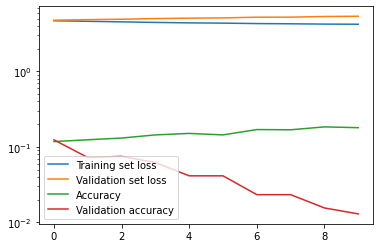

Epoch 1/10
15/15 [==============================] - 5s 335ms/step - loss: 4.4474 - accuracy: 0.1517 - val_loss: 4.7677 - val_accuracy: 0.0979
Epoch 2/10
15/15 [==============================] - 5s 332ms/step - loss: 4.4030 - accuracy: 0.1373 - val_loss: 4.9003 - val_accuracy: 0.0567
Epoch 3/10
15/15 [==============================] - 5s 330ms/step - loss: 4.2969 - accuracy: 0.1517 - val_loss: 4.9315 - val_accuracy: 0.0464
Epoch 4/10
15/15 [==============================] - 5s 334ms/step - loss: 4.2237 - accuracy: 0.1772 - val_loss: 5.0054 - val_accuracy: 0.0438
Epoch 5/10
15/15 [==============================] - 5s 329ms/step - loss: 4.2079 - accuracy: 0.1672 - val_loss: 5.0806 - val_accuracy: 0.0387
Epoch 6/10
15/15 [==============================] - 5s 332ms/step - loss: 4.2464 - accuracy: 0.1728 - val_loss: 5.0867 - val_accuracy: 0.0284
Epoch 7/10
15/15 [==============================] - 5s 328ms/step - loss: 4.1362 - accuracy: 0.1949 - val_loss: 5.1558 - val_accuracy: 0.0232
Epoch 

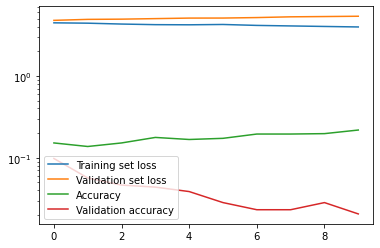

Epoch 1/10
15/15 [==============================] - 5s 334ms/step - loss: 4.3888 - accuracy: 0.1539 - val_loss: 4.3600 - val_accuracy: 0.1701
Epoch 2/10
15/15 [==============================] - 5s 331ms/step - loss: 4.2691 - accuracy: 0.1772 - val_loss: 4.4095 - val_accuracy: 0.1418
Epoch 3/10
15/15 [==============================] - 5s 329ms/step - loss: 4.2229 - accuracy: 0.1838 - val_loss: 4.5190 - val_accuracy: 0.1134
Epoch 4/10
15/15 [==============================] - 5s 330ms/step - loss: 4.1641 - accuracy: 0.1750 - val_loss: 4.6236 - val_accuracy: 0.1082
Epoch 5/10
15/15 [==============================] - 5s 330ms/step - loss: 4.0908 - accuracy: 0.1971 - val_loss: 4.6478 - val_accuracy: 0.0979
Epoch 6/10
15/15 [==============================] - 5s 332ms/step - loss: 4.0094 - accuracy: 0.2104 - val_loss: 4.7137 - val_accuracy: 0.0825
Epoch 7/10
15/15 [==============================] - 5s 333ms/step - loss: 3.9633 - accuracy: 0.2215 - val_loss: 4.7844 - val_accuracy: 0.0799
Epoch 

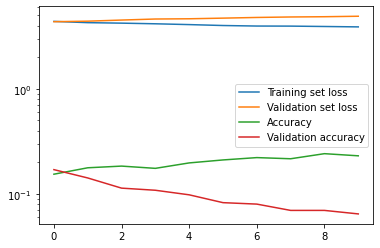

In [42]:
for train_index, test_index in sss.split(X2, y_):
    X_train, X_test = X2[train_index], X2[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    
    plt.plot(model2.history.history['loss'])
    plt.plot(model2.history.history['val_loss'])
    plt.plot(model2.history.history['accuracy'])
    plt.plot(model2.history.history['val_accuracy'])
    plt.legend(["Training set loss", "Validation set loss", "Accuracy", "Validation accuracy"])

    plt.yscale("log")
    plt.show()

In [43]:
y_pred = model2.predict(X2)         
y_pred = np.argmax(y_pred, axis = 1)

41/41 [==============================] - 2s 36ms/step


In [44]:
print("F1 score : ", f1_score(y_, y_pred, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred))
print("Precision score : ", precision_score(y_, y_pred, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred, average = 'weighted'))

F1 score :  0.23983601761154322
Accuracy :  0.1959721146398141
Precision score :  0.4392141096162017
Recall score :  0.1959721146398141


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Less complicated architecture

In [51]:
model = Sequential()
model.add(Input(shape=(input_dim)))
model.add(tf.keras.layers.Reshape((100, 520*3)))
model.add(LSTM(20))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 100, 1560)         0         
                                                                 
 lstm_6 (LSTM)               (None, 20)                126480    
                                                                 
 dense_9 (Dense)             (None, 231)               4851      
                                                                 
Total params: 131,331
Trainable params: 131,331
Non-trainable params: 0
_________________________________________________________________


In [53]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=1)

Epoch 1/10
15/15 [==============================] - 3s 125ms/step - loss: 5.4538 - accuracy: 0.0078 - val_loss: 5.4429 - val_accuracy: 0.0026
Epoch 2/10
15/15 [==============================] - 1s 91ms/step - loss: 5.4364 - accuracy: 0.0066 - val_loss: 5.4403 - val_accuracy: 0.0026
Epoch 3/10
15/15 [==============================] - 1s 86ms/step - loss: 5.4278 - accuracy: 0.0055 - val_loss: 5.4403 - val_accuracy: 0.0026
Epoch 4/10
15/15 [==============================] - 1s 80ms/step - loss: 5.4230 - accuracy: 0.0100 - val_loss: 5.4407 - val_accuracy: 0.0077
Epoch 5/10
15/15 [==============================] - 1s 83ms/step - loss: 5.4138 - accuracy: 0.0111 - val_loss: 5.4511 - val_accuracy: 0.0052
Epoch 6/10
15/15 [==============================] - 1s 83ms/step - loss: 5.4043 - accuracy: 0.0166 - val_loss: 5.4436 - val_accuracy: 0.0026
Epoch 7/10
15/15 [==============================] - 1s 80ms/step - loss: 5.3911 - accuracy: 0.0188 - val_loss: 5.4515 - val_accuracy: 0.0026
Epoch 8/10
1

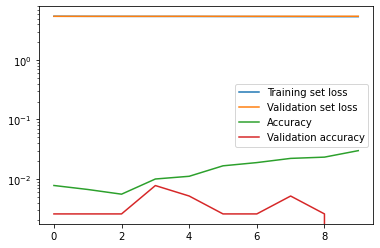

Epoch 1/10
15/15 [==============================] - 2s 108ms/step - loss: 5.3795 - accuracy: 0.0233 - val_loss: 5.3897 - val_accuracy: 0.0206
Epoch 2/10
15/15 [==============================] - 1s 87ms/step - loss: 5.3706 - accuracy: 0.0288 - val_loss: 5.3981 - val_accuracy: 0.0206
Epoch 3/10
15/15 [==============================] - 1s 83ms/step - loss: 5.3591 - accuracy: 0.0233 - val_loss: 5.3999 - val_accuracy: 0.0180
Epoch 4/10
15/15 [==============================] - 1s 81ms/step - loss: 5.3442 - accuracy: 0.0288 - val_loss: 5.3991 - val_accuracy: 0.0284
Epoch 5/10
15/15 [==============================] - 1s 81ms/step - loss: 5.3295 - accuracy: 0.0299 - val_loss: 5.3983 - val_accuracy: 0.0206
Epoch 6/10
15/15 [==============================] - 1s 87ms/step - loss: 5.3209 - accuracy: 0.0388 - val_loss: 5.3998 - val_accuracy: 0.0258
Epoch 7/10
15/15 [==============================] - 1s 82ms/step - loss: 5.3073 - accuracy: 0.0443 - val_loss: 5.4093 - val_accuracy: 0.0206
Epoch 8/10
1

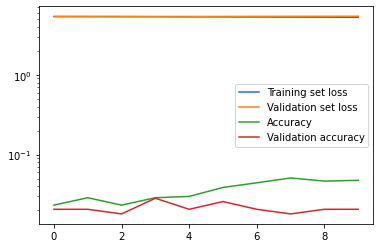

Epoch 1/10
15/15 [==============================] - 2s 104ms/step - loss: 5.3056 - accuracy: 0.0443 - val_loss: 5.3060 - val_accuracy: 0.0387
Epoch 2/10
15/15 [==============================] - 1s 89ms/step - loss: 5.2914 - accuracy: 0.0454 - val_loss: 5.3083 - val_accuracy: 0.0490
Epoch 3/10
15/15 [==============================] - 1s 86ms/step - loss: 5.2707 - accuracy: 0.0509 - val_loss: 5.3145 - val_accuracy: 0.0490
Epoch 4/10
15/15 [==============================] - 1s 87ms/step - loss: 5.2540 - accuracy: 0.0576 - val_loss: 5.3227 - val_accuracy: 0.0361
Epoch 5/10
15/15 [==============================] - 1s 87ms/step - loss: 5.2416 - accuracy: 0.0576 - val_loss: 5.3352 - val_accuracy: 0.0335
Epoch 6/10
15/15 [==============================] - 1s 86ms/step - loss: 5.2253 - accuracy: 0.0576 - val_loss: 5.3392 - val_accuracy: 0.0258
Epoch 7/10
15/15 [==============================] - 1s 86ms/step - loss: 5.2121 - accuracy: 0.0598 - val_loss: 5.3484 - val_accuracy: 0.0309
Epoch 8/10
1

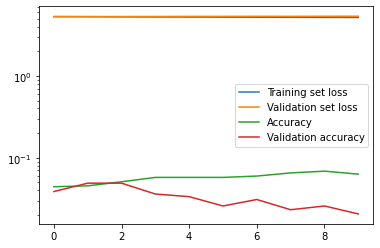

Epoch 1/10
15/15 [==============================] - 1s 96ms/step - loss: 5.2320 - accuracy: 0.0509 - val_loss: 5.2247 - val_accuracy: 0.0490
Epoch 2/10
15/15 [==============================] - 1s 91ms/step - loss: 5.2187 - accuracy: 0.0532 - val_loss: 5.2323 - val_accuracy: 0.0387
Epoch 3/10
15/15 [==============================] - 1s 95ms/step - loss: 5.2064 - accuracy: 0.0565 - val_loss: 5.2350 - val_accuracy: 0.0387
Epoch 4/10
15/15 [==============================] - 1s 91ms/step - loss: 5.1937 - accuracy: 0.0653 - val_loss: 5.2383 - val_accuracy: 0.0361
Epoch 5/10
15/15 [==============================] - 1s 94ms/step - loss: 5.1829 - accuracy: 0.0687 - val_loss: 5.2431 - val_accuracy: 0.0412
Epoch 6/10
15/15 [==============================] - 1s 93ms/step - loss: 5.1778 - accuracy: 0.0709 - val_loss: 5.2535 - val_accuracy: 0.0387
Epoch 7/10
15/15 [==============================] - 1s 91ms/step - loss: 5.1593 - accuracy: 0.0753 - val_loss: 5.2581 - val_accuracy: 0.0387
Epoch 8/10
15

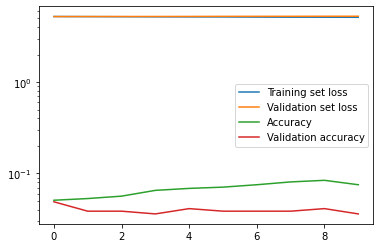

Epoch 1/10
15/15 [==============================] - 1s 94ms/step - loss: 5.1822 - accuracy: 0.0587 - val_loss: 5.1407 - val_accuracy: 0.0799
Epoch 2/10
15/15 [==============================] - 1s 87ms/step - loss: 5.1711 - accuracy: 0.0631 - val_loss: 5.1400 - val_accuracy: 0.0825
Epoch 3/10
15/15 [==============================] - 1s 88ms/step - loss: 5.1578 - accuracy: 0.0687 - val_loss: 5.1440 - val_accuracy: 0.0670
Epoch 4/10
15/15 [==============================] - 1s 88ms/step - loss: 5.1467 - accuracy: 0.0753 - val_loss: 5.1471 - val_accuracy: 0.0670
Epoch 5/10
15/15 [==============================] - 1s 88ms/step - loss: 5.1336 - accuracy: 0.0775 - val_loss: 5.1546 - val_accuracy: 0.0670
Epoch 6/10
15/15 [==============================] - 1s 89ms/step - loss: 5.1220 - accuracy: 0.0786 - val_loss: 5.1611 - val_accuracy: 0.0696
Epoch 7/10
15/15 [==============================] - 1s 87ms/step - loss: 5.1104 - accuracy: 0.0775 - val_loss: 5.1721 - val_accuracy: 0.0593
Epoch 8/10
15

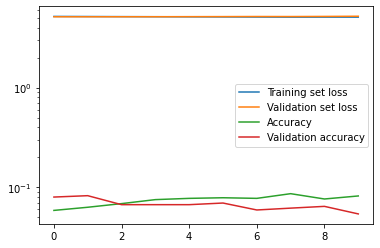

In [54]:
for train_index, test_index in sss.split(X, y_):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.legend(["Training set loss", "Validation set loss", "Accuracy", "Validation accuracy"])

    plt.yscale("log")
    plt.show()

In [55]:
y_pred = model.predict(X)         
y_pred = np.argmax(y_pred, axis = 1)

41/41 [==============================] - 1s 27ms/step


In [56]:
print("F1 score : ", f1_score(y_, y_pred, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred))
print("Precision score : ", precision_score(y_, y_pred, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred, average = 'weighted'))

F1 score :  0.061312219359322434
Accuracy :  0.07281177381874517
Precision score :  0.10240445444270131
Recall score :  0.07281177381874517


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
